In [6]:
from collections import defaultdict
import requests
import time, os

import numpy as np
import pandas as pd

import json, urllib3, string
from bs4 import BeautifulSoup

import pickle
from sqlalchemy import create_engine

from itertools import product
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from IPython.display import Image
import matplotlib.pylab as pylab

import re

import gender_guesser.detector as gender

import statsmodels.api as sm
from scipy.stats import chisquare
from sklearn.model_selection import train_test_split

## Load Pickle'd Data

Pickle

In [7]:
with open('datasets_dict.pickle', 'rb') as f:
    datasets_dict = pickle.load(f)

print("Loaded datasets:",list(datasets_dict.keys()))


Loaded datasets: ['merge', 'principals_names', 'id_directors', 'id_writers']


In [8]:
merge = datasets_dict['merge']
principals_names = datasets_dict['principals_names']
id_directors = datasets_dict['id_directors']
id_writers = datasets_dict['id_writers']

#### Gender identification

In [9]:
# Intialize gender guesser 
d = gender.Detector()

In [10]:
# API approach
# def pronoun_mode_api(name_id):
#     name_id = re.sub(r'^nm','',name_id)
#     person = ia.get_person(name_id,info=['biography'])
#     words = person['mini biography'][0]
#     patt = re.compile(r"(he|she|it|they|his|her|their) ",re.IGNORECASE)

def pronoun_mode(name_id):
    """
    takes in a name_id from imdb's names database and outputs the gender based on the 
    number of pronouns
    """
    url = "https://www.imdb.com/name/"+name_id+"/bio?ref_=nm_ov_bio_sm"
    try:
        response = requests.get(url)
        if response.status_code != 200:
#             print('error: page not found with', name_id)
            pronoun_mode = 'error - page not found'
        else:
            soup = BeautifulSoup(response.text)
            div = soup.find('div',class_='soda odd')
            if type(div) == type(None):
#                 print('bio not found with',name_id)
                pronoun_mode = "error - bio"
            else:
                bio = div.text.strip()
                patt = re.compile(r"(he|his|him|actor|she|her|actress|it|its|they|their|them)[\.,:]? ",re.IGNORECASE)
                matches = patt.findall(bio)
                if matches == []:
#                     print('pronouns not found in bio for',name_id)
                    pronoun_mode = 'error - no pronouns'
                else:
                    matches_series = pd.Series(matches).str.lower().value_counts().reset_index()
                    matches_series.loc[matches_series['index'].str.contains('he|his|him|actor'),'bio gender'] = 'male'
                    matches_series.loc[matches_series['index'].str.contains('she|her|actress'),'bio gender'] = 'female'
                    matches_series.loc[matches_series['index'].str.contains('it|its|they|their|them'),'bio gender'] = 'nb'
                    pronoun_mode = matches_series['bio gender'].value_counts().index[0]
    except Exception as e:
#         print(e)
#         print('error with',name_id)
        pronoun_mode = 'error - unknown'
    return pronoun_mode

In [11]:
listofnames = pd.Series(principals_names['nconst'].unique())

In [8]:
parts = {}
counter = 0
for i in range(9):
    start = counter
    increment = int(len(listofnames)/10)
    counter += increment
    print(start,counter)
    parts[i] = listofnames.iloc[start:counter]
start = counter
parts[9] = listofnames.iloc[start:]

[len(parts[i]) for i in parts.keys()]

0 3755
3755 7510
7510 11265
11265 15020
15020 18775
18775 22530
22530 26285
26285 30040
30040 33795


[3755, 3755, 3755, 3755, 3755, 3755, 3755, 3755, 3755, 3758]

In [9]:
parts[0].iloc[:5].apply(pronoun_mode)

0           male
1           male
2    error - bio
3    error - bio
4           male
dtype: object

In [ ]:
gender_bio={}

for i in range(10):
    gender_bio[i] = parts[i].apply(pronoun_mode)
    print('Part',i,'completed.')

In [16]:
gender = listofnames.apply(d.get_gender())

TypeError: get_gender() missing 1 required positional argument: 'name'

In [16]:
principals_counts = principals_names.copy()

principals_counts.loc[principals_counts['category']=='actor','gender'] = 'male'
principals_counts.loc[principals_counts['category']=='actress','gender'] = 'female'
principals_counts.loc[principals_counts['category'].isin(['actor','actress']),'category'] = 'cast'

gender_eda = principals_counts.groupby(['imdbid_tt','category','gender']).count()

principals_counts = principals_counts.groupby(['imdbid_tt','category','gender']).count()
principals_counts = principals_counts['firstName'].unstack(level='gender').reset_index().fillna(0)
principals_counts['_f_count'] = principals_counts['female'] + principals_counts['mostly_female']
principals_counts['_m_count'] = principals_counts['male'] + principals_counts['mostly_male']
principals_counts['_total_count'] = principals_counts['_m_count'] + principals_counts['_f_count'] \
                                + principals_counts['andy'] + principals_counts['unknown']
principals_counts['_unknown'] = 0
principals_counts.loc[principals_counts['_total_count'] == principals_counts['andy'] + principals_counts['unknown'],'_unknown'] = 1

principals_counts = pd.pivot_table(principals_counts,
                                   values=['_f_count','_m_count','_total_count','_unknown'],
                                   index=['imdbid_tt'] ,
                                   columns='category'
                                  ).reset_index().fillna(0)
principals_counts.columns = ['%s%s' % (b, a) for a, b in principals_counts.columns]
principals_counts = principals_counts.reindex(sorted(principals_counts.columns),axis=1)

KeyError: 'mostly_female'

In [94]:
director_counts = id_directors.groupby(['imdbid_tt','gender']).count()
director_counts = director_counts['firstName'].unstack(level='gender').reset_index().fillna(0)
director_counts['director_f_count'] = director_counts['female'] + director_counts['mostly_female']
director_counts['director_m_count'] = director_counts['male'] + director_counts['mostly_male']
director_counts['director_total_count'] = director_counts['director_m_count'] + director_counts['director_f_count'] \
                                + director_counts['andy'] + director_counts['unknown']
director_counts['unknown_dir_flag'] = 0
director_counts.loc[director_counts['director_total_count'] == director_counts['andy'] + director_counts['unknown'],'unknown_dir_flag'] = 1
director_counts = director_counts[['imdbid_tt','director_f_count','director_m_count','director_total_count','unknown_dir_flag']]
director_counts

gender,imdbid_tt,director_f_count,director_m_count,director_total_count,unknown_dir_flag
0,tt0000003,0.0,0.0,1.0,1
1,tt0000012,0.0,2.0,2.0,0
2,tt0000014,1.0,1.0,2.0,0
3,tt0000041,0.0,1.0,1.0,0
4,tt0000091,0.0,1.0,1.0,0
...,...,...,...,...,...
8767,tt9737798,0.0,1.0,1.0,0
8768,tt9766166,0.0,1.0,1.0,0
8769,tt9788496,0.0,3.0,4.0,0
8770,tt9806192,0.0,1.0,1.0,0


In [97]:
writer_counts = id_writers.groupby(['imdbid_tt','gender']).count()
writer_counts = writer_counts['firstName'].unstack(level='gender').reset_index().fillna(0)
writer_counts['writer_f_count'] = writer_counts['female'] + writer_counts['mostly_female']
writer_counts['writer_m_count'] = writer_counts['male'] + writer_counts['mostly_male']
writer_counts['writer_total_count'] = writer_counts['writer_m_count'] + writer_counts['writer_f_count'] \
                                + writer_counts['andy'] + writer_counts['unknown']
writer_counts['unknown_wri_flag'] = 0
writer_counts.loc[writer_counts['writer_total_count'] == writer_counts['andy'] + writer_counts['unknown'],'unknown_wri_flag'] = 1
writer_counts = writer_counts[['imdbid_tt','writer_f_count','writer_m_count','writer_total_count','unknown_wri_flag']]
writer_counts

gender,imdbid_tt,writer_f_count,writer_m_count,writer_total_count,unknown_wri_flag
0,tt0000091,0.0,1.0,1.0,0
1,tt0000211,0.0,1.0,1.0,0
2,tt0000230,0.0,1.0,1.0,0
3,tt0000306,0.0,1.0,1.0,0
4,tt0000413,0.0,1.0,1.0,0
...,...,...,...,...,...
8671,tt9737798,2.0,1.0,3.0,0
8672,tt9766166,0.0,2.0,2.0,0
8673,tt9788496,0.0,3.0,3.0,0
8674,tt9806192,0.0,2.0,2.0,0


In [499]:
# eda_graph = eda.groupby('category').sum()[['andy','female','male','mostly_female','mostly_male','unknown']]


eda_graph = gender_eda.reset_index().groupby(['category','gender']).sum().reset_index()

# eda_graph[eda_graph['category']=='writer']
# g = sns.FacetGrid(eda_graph[eda_graph['category']=='writer'],col='category',row='gender')
# g.map(sns.barplot,'firstName')

eda_graph[eda_graph['category']=='writer']

,category,gender,id,year,rating,title,imdbid,tconst,ordering,nconst,job,characters,primaryName,firstName
20,writer,andy,135,135,135,135,135,135,135,135,135,135,135,135
21,writer,female,2199,2199,2199,2199,2199,2199,2199,2199,2199,2199,2199,2199
22,writer,male,10551,10551,10551,10551,10551,10551,10551,10551,10551,10551,10551,10551
23,writer,mostly_female,286,286,286,286,286,286,286,286,286,286,286,286
24,writer,mostly_male,522,522,522,522,522,522,522,522,522,522,522,522
25,writer,unknown,1314,1314,1314,1314,1314,1314,1314,1314,1314,1314,1314,1269


In [473]:
principals_counts['writerf_']

,cast_f_count,cast_m_count,cast_total_count,cast_unknown,director_f_count,director_m_count,director_total_count,director_unknown,editor_f_count,editor_m_count,...,editor_unknown,imdbid_tt,producer_f_count,producer_m_count,producer_total_count,producer_unknown,writer_f_count,writer_m_count,writer_total_count,writer_unknown
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,tt0000003,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,...,0.0,tt0000012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,2.0,2.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0,...,0.0,tt0000014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,tt0000041,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,tt0000091,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8767,2.0,2.0,4.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,tt9737798,0.0,1.0,1.0,0.0,2.0,1.0,3.0,0.0
8768,2.0,2.0,4.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,tt9766166,1.0,0.0,1.0,0.0,0.0,2.0,2.0,0.0
8769,2.0,2.0,4.0,0.0,0.0,3.0,4.0,0.0,0.0,0.0,...,0.0,tt9788496,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0
8770,1.0,3.0,4.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,tt9806192,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0


In [177]:
# principals_names['gender'] = principals_names['firstName'].apply(d.get_gender)

,imdbid,id,rating,year,title,imdbid_tt,tconst,ordering,nconst,category,job,characters,primaryName,firstName,gender
4,0392728,8040,0,1888,Roundhay Garden Scene,tt0392728,tt0392728,5,nm1284117,director,\N,\N,Louis Aimé Augustin Le Prince,Louis,male
5,0000003,5433,0,1892,Pauvre Pierrot,tt0000003,tt0000003,1,nm0721526,director,\N,\N,Émile Reynaud,Émile,unknown
6,0000003,5433,0,1892,Pauvre Pierrot,tt0000003,tt0000003,2,nm1770680,producer,producer,\N,Julien Pappé,Julien,male
8,0000003,5433,0,1892,Pauvre Pierrot,tt0000003,tt0000003,4,nm5442200,editor,\N,\N,Tamara Pappé,Tamara,female
9,0132134,6200,0,1895,"Execution of Mary, Queen of Scots, The",tt0132134,tt0132134,1,nm0858405,actor,\N,"[""Queen Mary""]",Robert Thomae,Robert,male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86175,10243992,9437,3,2020,I&#39;m Your Woman,tt10243992,tt10243992,3,nm3429884,actor,\N,"[""Cal""]",Arinzé Kene,Arinzé,unknown
86176,10243992,9437,3,2020,I&#39;m Your Woman,tt10243992,tt10243992,4,nm11986662,actor,\N,"[""Harry""]",Jameson Charles,Jameson,male
86178,10243992,9437,3,2020,I&#39;m Your Woman,tt10243992,tt10243992,9,nm5000675,editor,\N,\N,Shayar Bhansali,Shayar,unknown
86179,6587640,9087,3,2020,Trolls World Tour,tt6587640,tt6587640,3,nm3417385,actress,\N,"[""Barb""]",Rachel Bloom,Rachel,female


In [ ]:
merge_director = merge.merge(director_counts,on='imdbid_tt',how='inner',validate='m:1')
merge_director_writer = merge_director.merge(writer_counts,on='imdbid_tt',how='inner',validate='m:1')

In [462]:
def update_counts(df,var):
    new_df = df.copy()
    for suffix in ['_f_count','_m_count','_total_count']:
        final_varname = var + suffix
        _x = final_varname + "_x"
        _y = final_varname + "_y"
        changed = var+'changed'
        new_df[final_varname] = new_df[_x]
        new_df.loc[new_df[_x]<new_df[_y],final_varname] = new_df[_y]
        new_df[changed] = 0
        new_df.loc[new_df[_x]<new_df[_y],changed] = 1
        new_df = new_df.drop(columns=[_x,_y,changed])
    return new_df

model_principals = merge_director_writer.merge(principals_counts,on='imdbid_tt',how='inner')
model_principals = update_counts(model_principals,'writer')
model_principals = update_counts(model_principals,'director')
model_principals = model_principals.drop(columns=['unknown_dir_flag','unknown_wri_flag'])

model_principals= model_principals[model_principals['cast_unknown']
                                    + model_principals['director_unknown']
                                    + model_principals['editor_unknown']
                                    + model_principals['producer_unknown']
                                    + model_principals['writer_unknown'] == 0]

model_principals['bechdel pass'] = 0
model_principals.loc[model_principals['rating'] == 3,'bechdel pass'] = 1

model_principals['writer_f_percent'] = model_principals['writer_f_count'] / model_principals['writer_total_count'] 
model_principals['director_f_percent'] = model_principals['director_f_count'] / model_principals['director_total_count']
model_principals['producer_f_percent'] = model_principals['producer_f_count'] / model_principals['producer_total_count']
model_principals['editor_f_percent'] = model_principals['editor_f_count'] / model_principals['editor_total_count']
model_principals['cast_f_percent'] = model_principals['cast_f_count'] / model_principals['cast_total_count']


model_principals['decade'] = (model_principals['year']//10)*10
model_principals = model_principals.join(pd.get_dummies(model_principals['decade'],drop_first=True))

print(len(model_principals))

7564


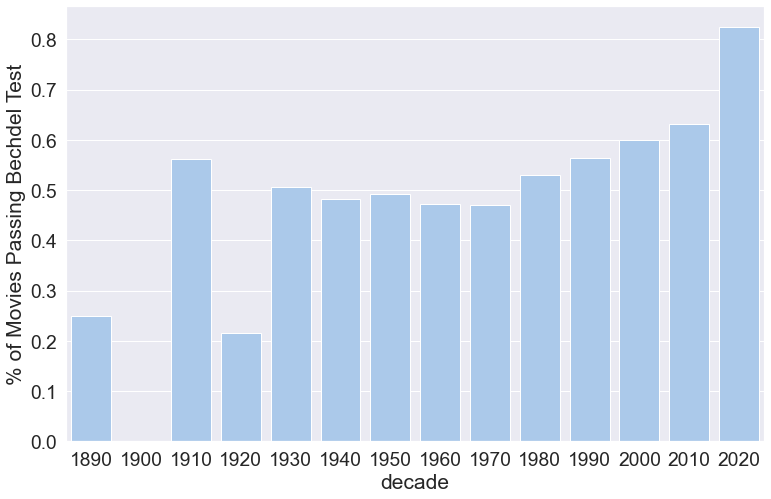

In [463]:
params = {'figure.figsize': (12.5, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
          
pylab.rcParams.update(params)

sns.set(font_scale=1.75)

groupby = model_principals.groupby('decade').agg({'bechdel pass':['sum','count']}).reset_index()

groupby['% of Movies Passing Bechdel Test'] = groupby['bechdel pass']['sum']/groupby['bechdel pass']['count']
groupby['count'] = groupby['bechdel pass']['count']
sns.set_color_codes('pastel')
sns.barplot(data = groupby, x='decade',y='% of Movies Passing Bechdel Test',color="b"); 

# Appendix - Extras

### Can opt to get the dubious column from getMovieByImbdId on Bechdel Test Movie List

In [80]:
# %%time

# dubious_data = []
# error_ids = []
# for row in bechdel_movies['imdbid']:
#     response = requests.get('http://bechdeltest.com/api/v1/getMovieByImdbId?imdbid='+str(row))
#     data = response.json()
#     if str(row) == data['imdbid']:
#         print('Match found with',str(row))
#         dubious_dict = {}
#         dubious_dict['imdbid'] = data['imdbid']
#         dubious_dict['dubious'] = data['dubious']
#         dubious_data.append(dubious_dict)
#     else:
#         print('Error with',str(row))
#         error_ids.append(str(row))
        
# print(error_ids)        
# pd.DataFrame(dubious_data)

### Query movies by ID using imdbpy library

In [25]:
from imdb import IMDb
from imdb.helpers import makeTextNotes

In [26]:
%%time
# create an instance of the IMDb class
ia = IMDb()

Wall time: 287 ms


In [27]:
ia.get_person_infoset()

['awards',
 'biography',
 'filmography',
 'genres links',
 'keywords links',
 'main',
 'news',
 'official sites',
 'other works',
 'publicity']

In [ ]:
# movie_info = ['cast', 'genres', 'year', 'producers', 'editors', 'editorial department', \
#  'production managers', 'assistant directors', 'script department', 'writer', \
#  'director', 'production companies']

In [205]:
# API Approach
# person = ia.get_person('0617588',info=['biography'])
# words = person['mini biography'][0]
# words

# Webscraping approach
name_id = 'nm0166380'
url = "https://www.imdb.com/name/"+name_id+"/bio?ref_=nm_ov_bio_sm"
# try:
response = requests.get(url)
if response.status_code != 200:
    print('error: page not found with', name_id)
    pronoun_mode = 'error'
else:
    soup = BeautifulSoup(response.text)
    div = soup.find('div',class_='soda odd')
    print(div)
    if type(div) == type(None):
        print('bio not found with',name_id)
        pronoun_mode = "error"
    else:
        bio = div.text.strip()
        patt = re.compile(r"(he|his|him|she|her|it|its|they|their|them) ",re.IGNORECASE)
        matches = patt.findall(bio)
        if matches == []:
            print('pronouns not found in bio for',name_id)
            pronoun_mode = 'error - no pronouns'
        else:
            matches_series = pd.Series(matches).str.lower().value_counts().reset_index()
            matches_series.loc[matches_series['index'].str.contains('he|his|him'),'bio gender'] = 'male'
            matches_series.loc[matches_series['index'].str.contains('she|her'),'bio gender'] = 'female'
            matches_series.loc[matches_series['index'].str.contains('it|its|they|their|them'),'bio gender'] = 'nb'
            pronoun_mode = matches_series['bio gender'].value_counts().index[0]
# except Exception as e:
#     print(e)
#     pronoun_mode = 'error'
pronoun_mode

<div class="soda odd">
<p>
              François Clerc is an actor, known for <a href="/title/tt0000014">L'arroseur arrosé</a> (1895).<br/>
</p>
</div>
pronouns not found in bio for nm0166380


'error - no pronouns'

In [106]:
patt = re.compile(r"(he|she|it|they|his|her|their) ",re.IGNORECASE)
print(patt.findall(words))
# print(list(pd.Series(patt.findall(words)).str.lower().value_counts().index))

['he', 'he', 'His', 'he', 'he', 'he', 'he', 'he', 'he']


In [39]:
movie = ia.get_movie('0133093')
plot=movie['plot'][0]
plot

'When a beautiful stranger leads computer hacker Neo to a forbidding underworld, he discovers the shocking truth--the life he knows is the elaborate deception of an evil cyber-intelligence.'

In [29]:
print(movie['directors'])
print(movie['director'])


[<Person id:0905154[http] name:_Lana Wachowski_>, <Person id:0905152[http] name:_Lilly Wachowski_>]
[<Person id:0905154[http] name:_Lana Wachowski_>, <Person id:0905152[http] name:_Lilly Wachowski_>]


# Buggy code

### Pickle Imported Data

In [136]:
# for item in datasets_zip[:3]:
#     to_pickle =item[1] + '.pickle'
#     print(to_pickle)
#     with open(to_pickle, 'wb') as f:
#         pickle.dump(item[0], f, pickle.HIGHEST_PROTOCOL)

bechdel_movies.pickle
title_crew.pickle
title_basics.pickle


In [137]:
# for item in datasets_zip[3:]:
#     to_pickle =item[1] + '.pickle'
#     print(to_pickle)
#     with open(to_pickle, 'wb') as f:
#         pickle.dump(item[0], f, pickle.HIGHEST_PROTOCOL)

title_principals.pickle
title_akas.pickle
name_basics.pickle


### Load Pickle'd Data when returning to this notebook

In [139]:
db_dict = {}

In [140]:
# for item in datasets_zip[:3]:
#     from_pickle =item[1] + '.pickle'
#     print(from_pickle)
#     with open(from_pickle, 'rb') as f:
#         db_dict[item[1]] = pickle.load(f)

bechdel_movies.pickle
title_crew.pickle
title_basics.pickle


In [157]:
# for item in datasets_zip[3:]:
#     from_pickle =item[1] + '.pickle'
#     print(from_pickle)
#     with open(from_pickle, 'rb') as f:
#         db_dict[item[1]] = pickle.load(f)

# Appendix - Old Code

In [ ]:
# engine = create_engine('postgresql://postgres:warroo:localhost@localhost:5432/tennis')

# title_principals = pd.read_csv('title.principals.tsv',sep='\t')

# # I'm choosing to name this table "aus_men"
# title_principals.to_sql('title_principals', engine, index=False)